In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , precision_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from os import listdir
%matplotlib inline

In [38]:
def crop_brain_contour(image, plot=False):
    """
    Crop the brain contour from an image by finding the largest external contour.

    Arguments:
        image: Input image (numpy array).
        plot: Boolean, whether to plot the original and cropped image.

    Returns:
        new_image: Cropped image containing the brain region.
    """
    # Convert the image to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours and select the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Determine the extreme points of the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the image using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Original Image')

        # Plot cropped image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Cropped Image')

        plt.tight_layout()
        plt.show()

    return new_image


In [42]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them in a memory-efficient way.
    Arguments:
        dir_list: list of strings representing file directories.
        image_size: tuple of (image_width, image_height).
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, 3).
        y: A numpy array with shape = (#_examples,).
    """
    X = []
    y = []

    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            file_path = f"{directory}/{filename}"
            
            # Load the image
            image = cv2.imread(file_path)
            if image is None:
                continue

            # Resize the image
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # Normalize the image
            image = image / 255.0

            # Append the processed image
            X.append(image)

            # Assign labels based on folder name
            folder_name = directory.split('/')[-1].lower()
            if folder_name == 'glioma':
                y.append(0)
            elif folder_name == 'meningioma':
                y.append(1)
            elif folder_name == 'notumor':
                y.append(2)
            elif folder_name == 'pituitary':
                y.append(3)

    # Convert lists to numpy arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    # Shuffle the data
    # X, y = shuffle(X, y, random_state=42)

    print(f'Number of examples: {len(X)}')
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    return X, y

In [44]:
training_path = 'brain-tumor-mri-dataset/Training/'
glioma = training_path + 'glioma' 
meningioma = training_path + 'meningioma'
notumor = training_path + 'notumor'
pituitary = training_path + 'pituitary'
IMG_WIDTH, IMG_HEIGHT = (299, 299)
X, y = load_data([glioma, meningioma , notumor , pituitary], (IMG_WIDTH, IMG_HEIGHT))

Number of examples: 5712
X shape: (5712, 299, 299, 3)
y shape: (5712,)


In [52]:
testing_path = 'brain-tumor-mri-dataset/Testing/'
glioma = testing_path + 'glioma' 
meningioma = testing_path + 'meningioma'
notumor = testing_path + 'notumor'
pituitary = testing_path + 'pituitary'
IMG_WIDTH, IMG_HEIGHT = (299, 299)
X_test, y_test = load_data([glioma, meningioma , notumor , pituitary], (IMG_WIDTH, IMG_HEIGHT))

Number of examples: 1311
X shape: (1311, 299, 299, 3)
y shape: (1311,)


In [58]:
X_flat = X.reshape(X.shape[0], -1)  # Flatten if needed
y_flat = y.ravel()  # Convert to 1D

In [62]:
start_time = time.time()  # Start Timer

model = LogisticRegression(max_iter=500) # take an obj from LogisticRegression() class

model.fit(X_flat, y_flat) # fit the model

end_time = time.time()  # End Timer

print(f"Execution Time: {end_time - start_time:.5f} seconds")

Execution Time: 1917.33151 seconds


In [63]:
X_flat_t = X_test.reshape(X_test.shape[0], -1)  # Flatten if needed
y_flat_t = y_test.ravel()  # Convert to 1D

In [64]:
X_flat_t , y_flat_t = shuffle(X_flat_t, y_flat_t, random_state=42) # Shuffle the flatten testset

In [65]:
# Evaluate the model
start_time = time.time()  # Start Timer

y_pred = model.predict(X_flat_t)

accuracy = accuracy_score(y_flat_t, y_pred)

end_time = time.time()  # End Timer

print("Accuracy: {:.2f}%".format(accuracy * 100))
#

Accuracy: 87.95%


In [66]:
# evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_flat_t, y_pred))
print("\nClassification Report:\n", classification_report(y_flat_t, y_pred))

Confusion Matrix:
 [[225  64   3   8]
 [ 42 244  10  10]
 [  0   4 401   0]
 [  6  10   1 283]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.79       300
           1       0.76      0.80      0.78       306
           2       0.97      0.99      0.98       405
           3       0.94      0.94      0.94       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311



In [67]:
precision = precision_score(y_flat_t, y_pred , average='macro')
recall = recall_score(y_flat_t, y_pred , average='macro')
f1_score = f1_score(y_flat_t, y_pred , average='macro')

In [68]:
precision

0.87210104878006

In [69]:
recall

0.8702106027596224

In [70]:
f1_score

0.8705557213599155

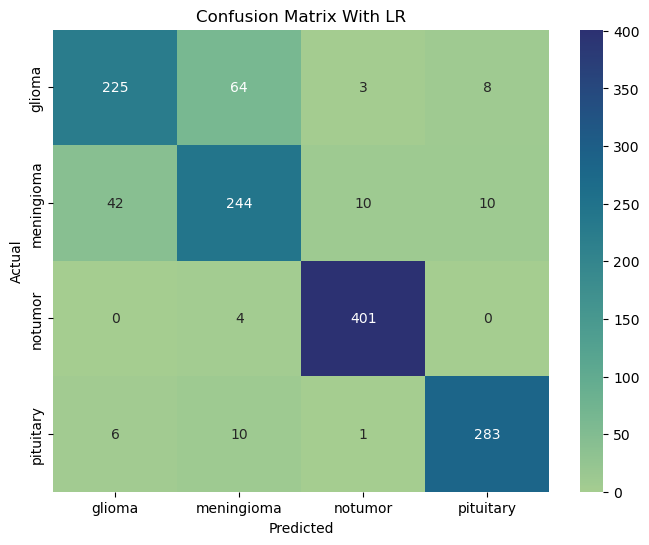

In [73]:
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_flat_t, y_pred), annot=True, fmt="d", cmap="crest", xticklabels=["glioma", "meningioma", "notumor" , "pituitary"], yticklabels=["glioma", "meningioma", "notumor" , "pituitary"])

# Labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix With LR")
plt.savefig("Confusion_Matrix_Logistic_reg")
plt.show()